In [ ]:
"""\
This script contains all the functions used to calculate & plot loop strengths in the paper
"Dynamics of microcompartment formation at the mitosis-to-G1 transition".

Examples show loop strength calculations & plots for condensin depletion data (Fig. 4)

Authors: Viraat Goel & James Jusuf
"""

In [1]:
# import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting

import bbi

### Generate cis-expected files

In [31]:
# An easier-to-read way for calculating the expected values in the ROIs (instead of across the entire genome)

resolutions = [250, 500, 1000, 1200, 1600, 2000]

for resolution in resolutions:

    conditions = ['0h','0.5h', '1h', '4h','8h']
    regions_mm39 = pd.DataFrame([['chr2',151920000,153000000,'Id1'],['chr8',84846629,85856629,'Klf1'],['chr8',122950000,124110000,'Cdt1'],['chr9',106675000,108600000,'Dag1'],['chr15',61810000,63684000,'Myc']],
                      columns=['chrom', 'start', 'end', 'name'])

    for condition in conditions:
        clr = cooler.Cooler(r'PATH_TO_DIRECTORY/RCMC_Condensin_'+condition+'_mm39.50.mcool::/resolutions/'+str(resolution))
        expected = cooltools.expected_cis(clr, view_df=regions_mm39, nproc=64, chunksize=1_000)
        expected.to_csv(r'PATH_TO_DIRECTORY/RCMC_Condensin_'+condition+'_ROIs_'+str(resolution)+'bpRes_mm39_cisExpected.tsv', sep='\t', index=False, header=True)

### Define functions for calculating signal

In [4]:
def get_zoomed_contact_map(clr, chr_name, start, end, res):

    start = int(np.floor(start/res))*res  # round down to nearest bin edge
    end = int(np.ceil(end/res))*res  # round up to nearest bin edge

    zoomed_contact_map = clr.matrix(balance=True).fetch((chr_name, start, end))

    N = end - start
    extent = np.array((0, N, N, 0)) + start

    return zoomed_contact_map, extent

def get_local_Ps_curve(clr, chr_name, start, end, res, region_extend, max_dist=None):

    start = int(np.floor(start/res))*res  # round down to nearest bin edge
    end = int(np.ceil(end/res))*res  # round up to nearest bin edge
    region_extend = int(np.round(region_extend/res))*res  # round to nearest integer number of bins
    
    if max_dist == None:
        max_dist = end - start + 2*region_extend - res  # maximum distance to get P(s) curve for
    max_dist_bins = max_dist // res

    if end - start <= 0:
        raise ValueError('End coordinate must be greater than start coordinate.')
    if end > clr.chromsizes[chr_name]:
        raise ValueError('End position exceeds the length of the chromosome.')
    if region_extend == 0:
        raise ValueError('region_extend is too small.')

    region_start = start - region_extend
    if region_start < 0:
        #warnings.warn('start bin extends beyond beginning of chromosome')
        region_start = 0  # truncate
    region_end = end + region_extend
    if region_end >= clr.chromsizes[chr_name]:
        #warnings.warn('end bin extends beyond end of chromosome')
        region_end = clr.chromsizes[chr_name]//res*res  # truncate

    contact_map_region = clr.matrix(balance=True).fetch((chr_name, region_start, region_end))

    dist_bins_arr = np.arange(0, max_dist_bins+1)  # array of dist_bins to calculate P(s) for
    dist_arr = res * dist_bins_arr
    mean_contact_prob_arr = np.zeros(len(dist_bins_arr))
    for i, dist_bins in enumerate(dist_bins_arr):
        contact_probs_along_diag = np.diag(contact_map_region, dist_bins)
        mean_contact_prob_arr[i] = np.nanmean(contact_probs_along_diag)  # ignore nan's
        
    return dist_arr, mean_contact_prob_arr

def get_image(clr, chr_name, start, end, pad, res):

    start = int(np.floor(start/res))*res  # round down to nearest bin edge
    end = int(np.ceil(end/res))*res  # round up to nearest bin edge
    pad = int(np.round(pad//res))*res  # round to nearest integer number of bins
    window_size_bins = 2*pad//res + 1
    
    region = clr.matrix(balance=True).fetch((chr_name, start-pad, end+pad))
    
    image = region[:window_size_bins,-window_size_bins:]
    
    x_low = end-pad-res
    x_high = end+pad
    y_low = start-pad
    y_high = start+pad+res
    extent = np.array((x_low, x_high, y_high, y_low))
    
    return image, extent

def get_background_image(mean_contact_prob_arr, start, end, pad, res):

    start = int(np.floor(start/res))*res  # round down to nearest bin edge
    end = int(np.ceil(end/res))*res  # round up to nearest bin edge
    pad_bins = pad // res
    loop_size_bins = (end - start - 1) // res

    dist_bins_low = loop_size_bins - 2*pad_bins
    dist_bins_high = loop_size_bins + 2*pad_bins
    dist_bins_arr = np.arange(dist_bins_low, dist_bins_high)

    if dist_bins_low <= 0:
        raise ValueError('pad is too large, image bounds extend to/beyond main diagonal')
    if dist_bins_high > res*len(mean_contact_prob_arr):
        raise ValueError('pad is too large, image bounds extend beyond region with available P(s) data; decrease pad or increase region size or max_dist')

    bg_img = np.zeros((2*pad_bins+1, 2*pad_bins+1))

    for i in range(bg_img.shape[0]):
        for j in range(bg_img.shape[1]):
            dist_bins = loop_size_bins + j - i
            bg_img[i, j] = mean_contact_prob_arr[dist_bins]
            
    x_low = end-pad-res
    x_high = end+pad
    y_low = start-pad
    y_high = start+pad+res
    extent = (x_low, x_high, y_high, y_low)
    
    return bg_img, extent

def gaussian_2D(x_arr, A, x0, y0, sigma_x, sigma_y, c):
    return A * np.exp(-(x_arr[0]-x0)**2/(2*sigma_x**2)-(x_arr[1]-y0)**2/(2*sigma_y**2)) + c

### Define global parameters

In [10]:
# Loop quantification parameters
pad = 5000
res = 500
region_extend = 100000

#List of mcool conditions as strings
conditions = ["0h", "0.5h", "1h", "4h", "8h"]

#List of loop types as strings
loopTypesNames = ["P-P", "E-P", "E-E", "P-CTCF", "E-CTCF", "CTCF-CTCF", "P-other", "E-other", "CTCF-other", "other-other"]

#Lists of mcool and cis-expected files
clrFiles = []
expectedFiles = []

for condition in conditions:
    clrFiles.append('COOLER_FILES_DIRECTORY/RCMC_Condensin_'+condition+'_mm39.merged.50.mcool')
    expectedFiles.append('EXPECTED_FILES_DIRECTORY/Condensin_'+condition+'_'+str(res)+'bpRes_mm39.tsv')

#List of loop file locations (bedpe)
loopFiles = []

for loopType in loopTypesNames:
    loopFiles.append('FILE_PATH_TO_LOOP_FILES/'+loopType+'.bedpe')

    
#Specify the RCMC regions of the mcools to look at (format: chromosome (string), start (number), end (number), name of region (string))
regions = pd.DataFrame([['chr2',151920000,153000000,'Id1'],['chr8',84846629,85856629,'Klf1'],['chr8',122950000,124110000,'Cdt1'],['chr9',106675000,108600000,'Dag1'],['chr15',61810000,63684000,'Myc']],
                  columns=['chrom', 'start', 'end', 'name'])

#Set save directory
saveDir = 'SAVE_DIRECTORY'

### Calculate loop strengths
##### Load in loop calls and calculate loop distances, calculate strength scores, both observed-over-expected (image / background) and absolute (just image), and create a single pandas dataframe with all calculated strengths and save it

In [ ]:
# Run over loop types (e.g., P-P, E-P, CTCF-CTCF) one-by-one to calculate loop strengths
classification = 'exclusive' # 'inclusive' to cover all loops, 'exclusive' to exclude CRE (P-P, E-P, E-E) loops with CTCF

for loopType in loopTypesNames:
    loopFile = 'FILE_PATH_TO_LOOP_FILES/'+classification+'/'+loopType+'.bedpe'
    
    #load the list of called loops (bedpe)
    df_full = pd.read_csv(loopFile, sep='\t', header=None, index_col=None, names=('chr1','left1','right1','chr2','left2','right2'))
    df_full['chr'] = df_full['chr1']
    df_full['left'] = (df_full['left1'] + df_full['right1']) // 2
    df_full['right'] = (df_full['left2'] + df_full['right2']) // 2
    
    df_temp = df_full.loc[:, ['chr', 'left', 'right']]
    df_temp['distance'] = df_temp['right'] - df_temp['left']
    df_distFilt = df_temp.loc[df_temp['distance'] > 12000] # drop the 58 loops that are <12kb in size since contact distances have to be at least double the size of the pad for the script to work
    df_distFilt.reset_index(drop=True, inplace=True)
    df = df_distFilt.copy()
    df_distFilt

    allObsOverExpScores = []
    allAbsoluteScores = []

    for filename in clrFiles:
        clr = cooler.Cooler(f'{filename}::/resolutions/{res}')

        obsOverExpScores = []
        absoluteScores = []

        i = 0
        while (i < len(df)):
            # quantify a single loop
            chr_name = df.loc[i, 'chr']
            left = df.loc[i,'left']
            right = df.loc[i,'right']

            image, extent = get_image(clr, chr_name, left, right, pad=pad, res=res)
            x, y = get_local_Ps_curve(clr, chr_name, left, right, res=res, region_extend=region_extend, max_dist=None)
            bg_image, extent = get_background_image(y, left, right, pad=pad, res=res)

            obsOverExpScore = np.nansum(image / bg_image)
            obsOverExpScores.append(obsOverExpScore)

            absoluteScore = np.nansum(image)
            absoluteScores.append(absoluteScore)

            # if (i % 25 == 0): print(i)
            i += 1

        allObsOverExpScores.append(obsOverExpScores)
        allAbsoluteScores.append(absoluteScores)

        print('Done with ' + filename)

    merged_df = df_distFilt.copy()
    merged_df['0h_str_OoE'] = allObsOverExpScores[0]
    merged_df['0.5h_str_OoE'] = allObsOverExpScores[1]
    merged_df['1h_str_OoE'] = allObsOverExpScores[2]
    merged_df['4h_str_OoE'] = allObsOverExpScores[3]
    merged_df['8h_str_OoE'] = allObsOverExpScores[4]
    merged_df['0h_str_Abs'] = allAbsoluteScores[0]
    merged_df['0.5h_str_Abs'] = allAbsoluteScores[1]
    merged_df['1h_str_Abs'] = allAbsoluteScores[2]
    merged_df['4h_str_Abs'] = allAbsoluteScores[3]
    merged_df['8h_str_Abs'] = allAbsoluteScores[4]
    merged_df
    merged_df.to_csv('FILE_PATH_TO_SAVE_DIRECTORY/' + classification+'/' + loopType + '_REST_OF_FILE_NAME.tsv', index=False, sep="\t")

### Extract calculated loop strengths into arrays

In [28]:
loopStrDirectory = 'LOOP_STRENGTHS_DIRECTORY' + classification + '/'
strengthType = 'OoE' # Either 'OoE' or 'Abs'

str0hAll = []
strHalfhAll = []
str1hAll = []
str4hAll = []
str8hAll = []

for loopType in loopTypesNames:
    loopStrengths = pd.read_csv(loopStrDirectory + loopType + '_REST_OF_FILE_NAME.tsv', sep='\t')

    # Extract the loop strengths into an array and remove null values
    str0h = loopStrengths['0h_str_'+strengthType].to_numpy()
    strHalfh = loopStrengths['0.5h_str_'+strengthType].to_numpy()
    str1h = loopStrengths['1h_str_'+strengthType].to_numpy()
    str4h = loopStrengths['4h_str_'+strengthType].to_numpy()
    str8h = loopStrengths['8h_str_'+strengthType].to_numpy()

    # Add data to matrix for consolidated plotting
    str0hAll.append(str0h)
    strHalfhAll.append(strHalfh)
    str1hAll.append(str1h)
    str4hAll.append(str4h)
    str8hAll.append(str8h)

### Plot loop strengths

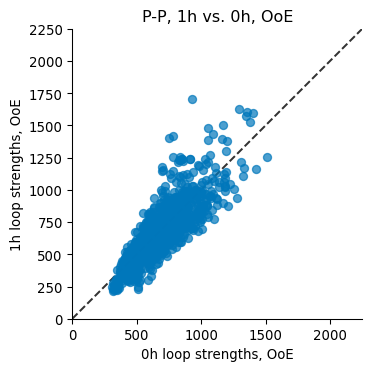

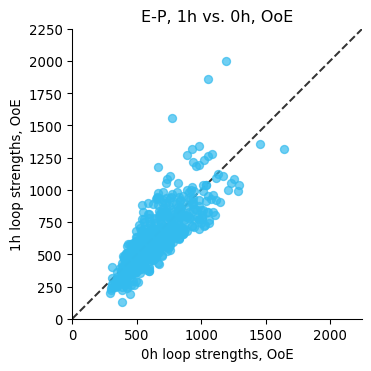

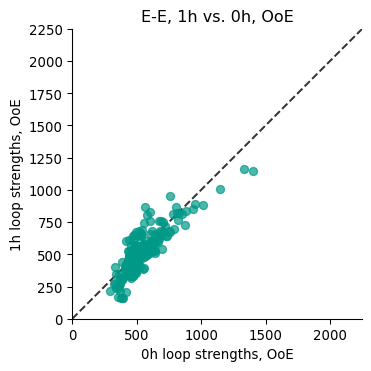

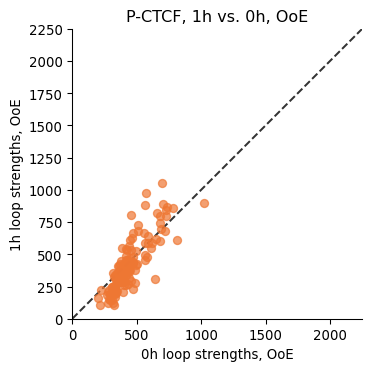

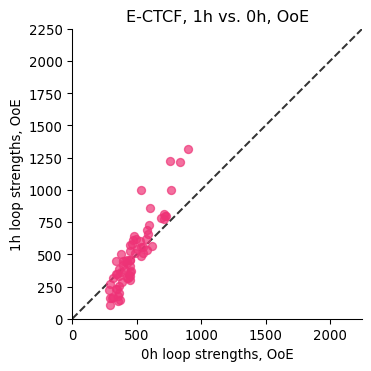

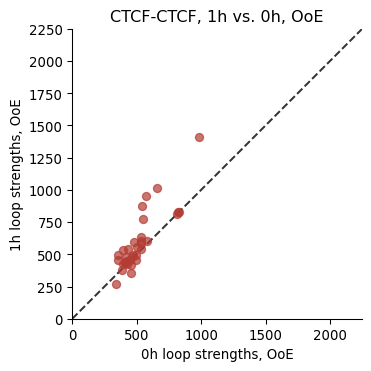

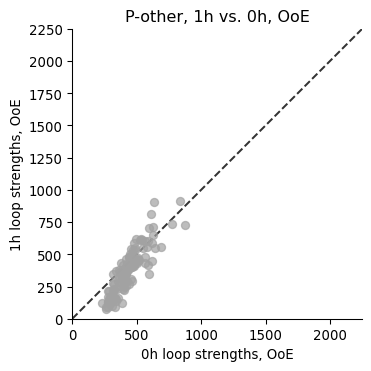

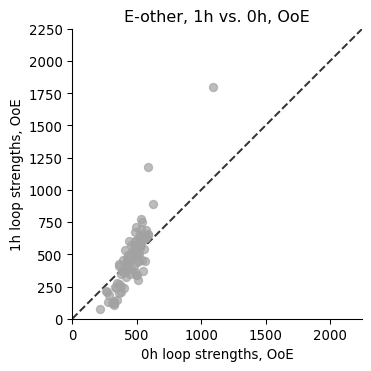

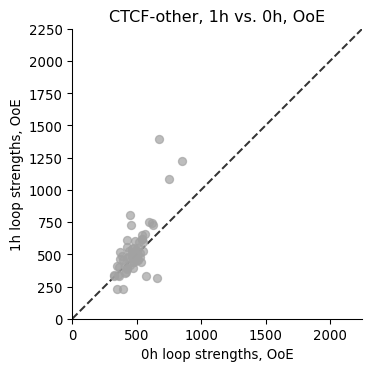

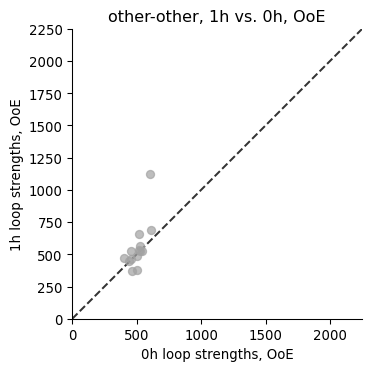

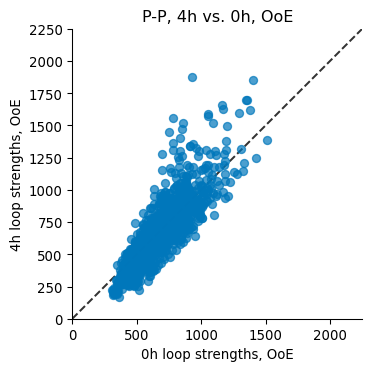

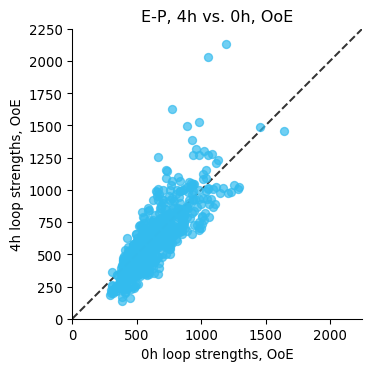

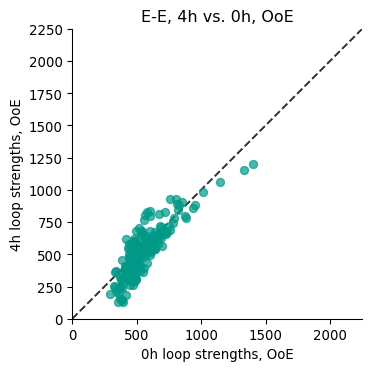

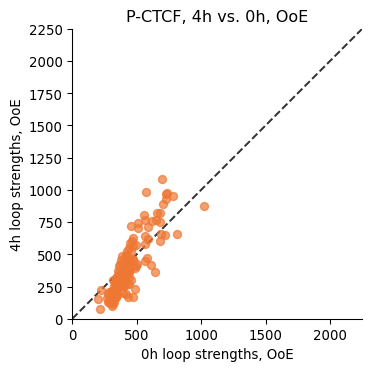

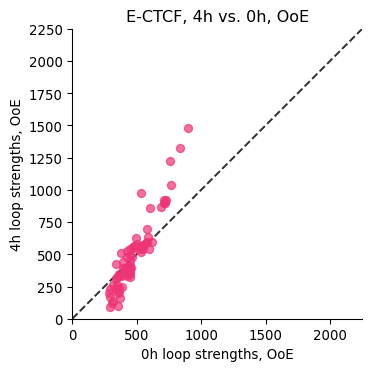

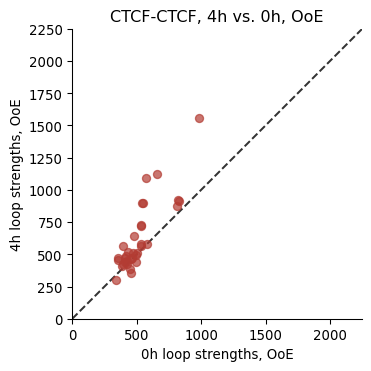

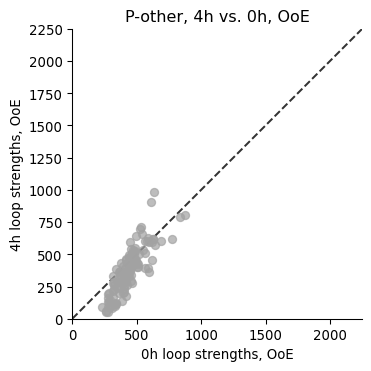

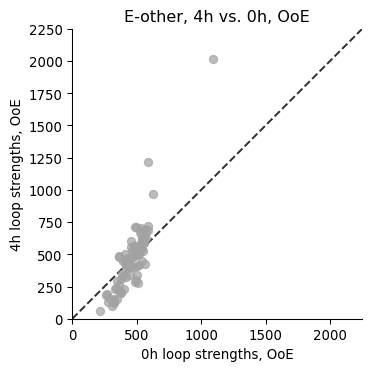

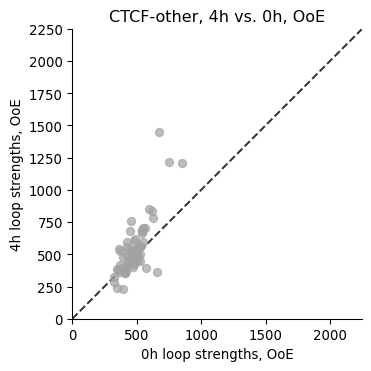

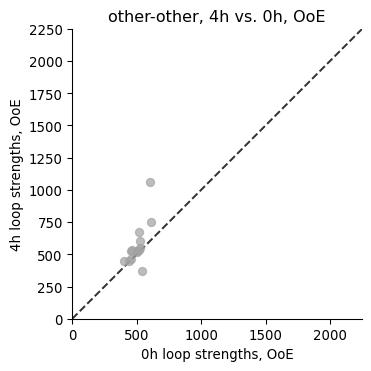

In [30]:
plotsDirectory = 'PLOTS_DIRECTORY/'
loopTypesNames = ["P-P", "E-P", "E-E", "P-CTCF", "E-CTCF", "CTCF-CTCF", "P-other", "E-other", "CTCF-other", "other-other"]
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#EE3377", "#B33C33", "#A2A2A2", "#A2A2A2", "#A2A2A2", "#A2A2A2"]

# Define the plotting pairs of interest and their corresponding labels
comboXs = [str0hAll, str0hAll]
comboYs = [str1hAll, str4hAll]

comboXLabels = ['0h', '0h']
comboYLabels = ['1h', '4h']

# Plotting
for i in range(len(comboXs)):
    for j in range(len(loopTypesNames)):
        X = comboXs[i]
        Y = comboYs[i]
        XLabel = comboXLabels[i]
        YLabel = comboYLabels[i]

        fig, ax = plt.subplots()

        plotX = X[j]
        plotY = Y[j]

        ax.scatter(plotX, plotY, label=loopTypesNames[j] + ', all', c=colors[j], edgecolors=colors[j], alpha=0.7)

        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        lims = [0, 2250] # set consistent limits for all plots, wide enough to capture all data points

        ax.plot(lims, lims, '--', c='#333333', zorder=0)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_xlabel(XLabel + ' loop strengths, ' + strengthType)
        ax.set_ylabel(YLabel + ' loop strengths, ' + strengthType)
        ax.set_title(loopTypesNames[j] + ', ' + YLabel + ' vs. ' + XLabel + ', ' + strengthType)
        #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        right_side = ax.spines["right"]
        top_side = ax.spines["top"]
        right_side.set_visible(False)
        top_side.set_visible(False)
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(plotsDirectory + 'CondensinDepletion_' + YLabel + 'vs' + XLabel + '_' + loopTypesNames[j] + '.svg',dpi=1200)